In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img,(kernel_size, kernel_size),0)

def canny(img, low=70, high=210):
    return cv2.Canny(img, low, high)

def roi(img, vertices, color3=(255,255,255), color1=255):
    
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        color = color3
    else:
        color=color1
    cv2.fillPoly(mask, vertices, color)
    ROI_image = cv2.bitwise_and(img, mask)
    return ROI_image

def draw_lines(img, lines, color=[0,0,255], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap): 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)

    return lines

def weighted_img(img, initial_img, alpha=1, beta=1., lam=0.): 
    return cv2.addWeighted(initial_img, alpha, img, beta, lam)

def img_show(origin, transformation):
    #bgr->rgb
    origin = origin[:,:,::-1]
    transformation = transformation[:,:,::-1]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=((10,10)))
    ax[0].set_title('origin image')
    ax[0].imshow(origin)
    ax[1].set_title('transformation image')
    ax[1].imshow(transformation)
    plt.show()
    
def run():
    image = cv2.imread('../lane/lane_2.jpg')
    height, width = image.shape[:2]
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img,3)
    canny_img = canny(blur_img, 70, 210)
    vertices = np.array([[(50,height),(width/2-45, height/2+60), (width/2+45, height/2+60), (width-50,height)]], dtype=np.int32)
    ROI_img = roi(canny_img, vertices)
    hough_img = hough_lines(ROI_img, 1, np.pi/180, 30, 10, 20)
    result = weighted_img(hough_img, image)
    img_show(image, result)

In [2]:
image = cv2.imread('../lane/lane_2.jpg')
height, width = image.shape[:2]
gray_img = grayscale(image)
blur_img = gaussian_blur(gray_img, 3)
canny_img = canny(blur_img, 70, 210)
vertices = np.array([[(50,height),(width/2-45, height/2+60), (width/2+45, height/2+60), (width-50,height)]], dtype=np.int32)
ROI_img = roi(canny_img, vertices)
line_arr =hough_lines(ROI_img, 1, np.pi/180, 30, 10, 20)

In [3]:
np.shape(line_arr)

(75, 1, 4)

In [4]:
line_arr = np.squeeze(line_arr)
np.shape(line_arr)

(75, 4)

In [16]:
slope_degree = np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2])*180/np.pi

In [17]:
line_arr = line_arr[np.abs(slope_degree)<160]
slope_degree = slope_degree[np.abs(slope_degree)<160]

line_arr = line_arr[np.abs(slope_degree)>95]
slope_degree = slope_degree[np.abs(slope_degree)>95]

In [40]:
L_lines, R_lines = line_arr[(slope_degree>0),:], line_arr[(slope_degree<0),:]
#L == +gradient
#R == -gradient

In [51]:
def get_fitline(img, f_lines): # 대표선 구하기   
    #lines = np.squeeze(f_lines)
    lines = f_lines.reshape(f_lines.shape[0]*2,2)
    rows,cols = img.shape[:2]
    output = cv2.fitLine(lines,cv2.DIST_L2,0, 0.01, 0.01)
    vx, vy, x, y = output[0], output[1], output[2], output[3]
    x1, y1 = int(((img.shape[0]-1)-y)/vy*vx + x) , img.shape[0]-1
    x2, y2 = int(((img.shape[0]/2+100)-y)/vy*vx + x) , int(img.shape[0]/2+100)
    
    result = [x1,y1,x2,y2]
    return result

def draw_fit_line(img, lines, color=[255, 0, 0], thickness=10): # 대표선 그리기
        cv2.line(img, (lines[0], lines[1]), (lines[2], lines[3]), color, thickness)

In [52]:
temp = np.zeros((image.shape[0],image.shape[1],3),dtype=np.uint8)
#L_lines, R_lines = L_lines[:,None], R_lines[:,None]
left_fit_line = get_fitline(image, L_lines)
right_fit_line = get_fitline(image,R_lines)

In [54]:
draw_fit_line(temp, left_fit_line)
draw_fit_line(temp, right_fit_line)
result = weighted_img(temp, image)

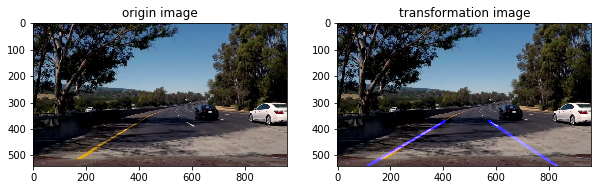

In [56]:
img_show(image, result)